In [1]:
import os
from datetime import datetime, timedelta
import ipywidgets as widgets
import plotly.graph_objs as go
import yfinance as yf
import pandas as pd
from IPython.display import display

In [2]:
views = {
    "Raw Data": lambda x, y: x,
    "Percent Change": lambda x, y: x.pct_change(),
    "Rolling Average": lambda x, y: x.rolling(y).mean(),
    "Rolling Variance": lambda x, y: x.rolling(y).var(),
    "Rolling Standard Deviation": lambda x, y: x.rolling(y).var() ** 0.5,
    "Rolling Coefficient of Variation": lambda x, y: (x.rolling(y).var() ** 0.5)
    / (x.rolling(y).mean()),
}

def render_plotly(fig):
    """Dynamically decides renderer given system environment"""
    if os.environ.get('SERVER_SOFTWARE','jupyter').startswith('voila'):
        fig.show(config={"showTips": False}, renderer="notebook")

def format_plotly(fig, calc, data, start, end):
    fig.update_yaxes(title=None)
    fig.update_xaxes(title=None)
    fig_title = f"{calc} of {data} from {start.strftime('%Y/%m/%d')} to {end.strftime('%Y/%m/%d')}"
    fig.update_layout(
        autosize=False,
        width=1000,
        height=500,
        title={
            "text": fig_title,
            "y": 0.95,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
    )


last_tickers = ""

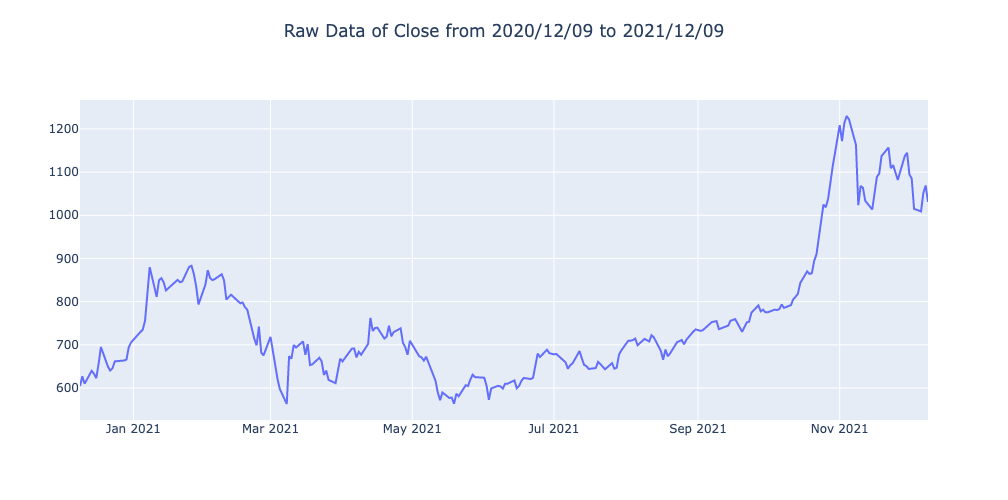

In [3]:
def view_chart(calculation, data, rolling, start, end, tickers):
    global last_tickers, df
    if tickers and tickers[-1] == ",":
        if tickers != last_tickers:
            df = yf.download(tickers, period="max", progress=False)
            last_tickers = tickers

        start_n = datetime(start.year, start.month, start.day)
        end_n = datetime(end.year, end.month, end.day)
        calcs = views[calculation](df[data], rolling)
        selection = calcs.loc[(calcs.index >= start_n) & (calcs.index <= end_n)]
        fig = go.Figure()

        if isinstance(selection, pd.Series):
            fig.add_trace(
                go.Scatter(
                    x=selection.index, y=selection, mode="lines", name=tickers[:-1]
                )
            )
        else:
            for item in selection:
                fig.add_trace(
                    go.Scatter(
                        x=selection.index,
                        y=selection[item],
                        mode="lines",
                        name=item.upper(),
                    )
                )

        format_plotly(fig, calculation, data, start, end)
        # Jupyter-lab and Google Colab: do not use renderer argument
        # VS Code: cocalc
        # Voila: notebook, notebook_connected
        fig.show(config={"showTips": False})


calc_widget = widgets.Dropdown(options=list(views.keys()), value="Raw Data")
data_widget = widgets.Dropdown(
    options=["Open", "Close", "High", "Low", "Volume"], value="Close"
)
rolling_widget = widgets.Dropdown(options=list(range(2, 101)), value=60)
start_widget = widgets.DatePicker(value=datetime.today() - timedelta(days=365))
end_widget = widgets.DatePicker(value=datetime.today())
tickers_widget = widgets.Text(value="TSLA,")
controls = widgets.VBox([calc_widget, data_widget, rolling_widget, start_widget, end_widget, tickers_widget])

stocks_view = widgets.interactive_output(
    view_chart,
    {"calculation": calc_widget,
    "data": data_widget,
    "rolling": rolling_widget,
    "start": start_widget,
    "end": end_widget,
    "tickers": tickers_widget,
    }
)

title_html = """<h1>Stock Analysis Dashboard</h1>"""
app_contents = [widgets.HTML(title_html), controls, stocks_view]
app = widgets.VBox(app_contents)

display(app)
